In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import tensorflow as tf
import pandas as pd


# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

#  Import and read the charity_data.csv.

application_df = pd.read_csv("Resources/charity_data.csv")
application_df

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...,...,...
34294,996009318,THE LIONS CLUB OF HONOLULU KAMEHAMEHA,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,996010315,INTERNATIONAL ASSOCIATION OF LIONS CLUBS,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,996012607,PTA HAWAII CONGRESS,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,996015768,AMERICAN FEDERATION OF GOVERNMENT EMPLOYEES LO...,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = pd.DataFrame(application_df)
application_df = application_df.drop(['EIN', 'NAME'], axis=1)
application_df

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
...,...,...,...,...,...,...,...,...,...,...
34294,T4,Independent,C1000,ProductDev,Association,1,0,N,5000,0
34295,T4,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
34296,T3,CompanySponsored,C2000,Preservation,Association,1,0,N,5000,0
34297,T5,Independent,C3000,ProductDev,Association,1,0,N,5000,1


In [3]:
application_df["ASK_AMT"]

0            5000
1          108590
2            5000
3            6692
4          142590
           ...   
34294        5000
34295        5000
34296        5000
34297        5000
34298    36500179
Name: ASK_AMT, Length: 34299, dtype: int64

In [4]:
# Determine the number of unique values in each column.
# For those columns that have more than 10 unique values, determine the number of data points for 
# each unique value.

application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [5]:
app_type_counts = application_df.APPLICATION_TYPE.value_counts()
app_type_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

# (circling back) VARIATION 4 - scale ASK_AMT

In [6]:
# Exploring ASK_AMT

ask_amt_counts = application_df.ASK_AMT.value_counts()
ask_amt_counts

5000       25398
10478          3
15583          3
6725           3
63981          3
           ...  
772556         1
70103          1
27096          1
25049          1
1138700        1
Name: ASK_AMT, Length: 8747, dtype: int64

<AxesSubplot:ylabel='Density'>

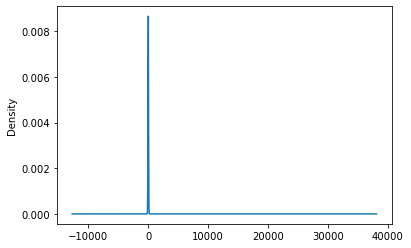

In [7]:
# this density plot suggests that there is almost only one value of ask_amt and should create a single df to scale
ask_amt_counts.plot.density()

In [8]:
# isolate this column in its own df
df = pd.DataFrame(application_df["ASK_AMT"], index=application_df.index)
df

,ASK_AMT
0,5000
1,108590
2,5000
3,6692
4,142590
...,...
34294,5000
34295,5000
34296,5000
34297,5000


In [9]:
# scale ASK_AMT column
scaler = MinMaxScaler()
ask_amt_scaled = scaler.fit_transform(df[['ASK_AMT']])
ask_amt_scaled


array([[0.00000000e+00],
       [1.20484291e-05],
       [0.00000000e+00],
       ...,
       [0.00000000e+00],
       [0.00000000e+00],
       [4.24471066e-03]])

In [10]:
ask_amt_scaled_df = pd.DataFrame(ask_amt_scaled, columns=["ASK_AMT (scaled)"])
ask_amt_scaled_df

,ASK_AMT (scaled)
0,0.000000e+00
1,1.204843e-05
2,0.000000e+00
3,1.967945e-07
4,1.600293e-05
...,...
34294,0.000000e+00
34295,0.000000e+00
34296,0.000000e+00
34297,0.000000e+00


In [11]:
# drop ASK_AMT from application_df and then concat ask_amt_scaled_df to

 # VARIATION 1 - REDUCING NUMBER OF COLUMNS

In [12]:
# Determine which values to replace if counts are less than 1000 (WAS 500)
replace_app_types = list(app_type_counts[app_type_counts < 1000].index)

# Replace in dataframe
for app in replace_app_types:
   application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts() #at <1000 Other is the second highest group (maybe not a good idea
    # but proceeding anyway)

T3       27037
Other     2266
T4        1542
T6        1216
T5        1173
T19       1065
Name: APPLICATION_TYPE, dtype: int64

In [13]:
# Look at CLASSIFICATION value counts for binning
cls_counts = application_df.CLASSIFICATION.value_counts()
cls_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C2561        1
C2380        1
C1820        1
C1900        1
C4120        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [14]:
# Determine which values to replace if counts are less than 2500 (WAS 1000)
replace_class = list(cls_counts[cls_counts < 2500].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful # Other was 4th highest group at <1000, but at <2500 is 3rd highest
    # group but proceeding anyway
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
Other     6062
C1200     4837
Name: CLASSIFICATION, dtype: int64

In [15]:
# Generate our categorical variable lists
# Generate our categorical variable list
application_cat = application_df.dtypes[application_df.dtypes == "object"].index.tolist()
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [16]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe (with variation #1 we are down 5 columns so far)
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,left_index=True, right_index=True)
application_df = application_df.drop(application_cat,1)
application_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
application_df = pd.concat([ask_amt_scaled_df, application_df], axis=1)
application_df.head(10)

,ASK_AMT (scaled),STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.000000e+00,1,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.204843e-05,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000000e+00,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.967945e-07,1,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.600293e-05,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,0.000000e+00,1,5000,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,3.076601e-06,1,31452,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,8.726679e-04,1,7508025,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
8,1.039673e-05,1,94389,1,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.000000e+00,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [19]:
#look application_df.describe(include='all')at dataframe to see if any more columns can be removed from X 
# (y=target = is_successful)

application_df.describe(include='all')

,ASK_AMT (scaled),STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
count,3.429900e+04,34299.000000,3.429900e+04,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,...,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000,34299.000000
mean,3.215006e-04,0.999854,2.769199e+06,0.532406,0.066066,0.031050,0.788274,0.044958,0.034199,0.035453,...,0.021225,0.015831,0.098370,0.006997,0.027843,0.109245,0.004053,0.005394,0.999213,0.000787
std,1.013404e-02,0.012073,8.713045e+07,0.498956,0.248401,0.173457,0.408538,0.207214,0.181743,0.184924,...,0.144136,0.124825,0.297819,0.083358,0.164526,0.311951,0.063532,0.073245,0.028046,0.028046
min,0.000000e+00,0.000000,5.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,1.000000,5.000000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000e+00,1.000000,5.000000e+03,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,3.189187e-07,1.000000,7.742000e+03,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000e+00,1.000000,8.597806e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
# Split our preprocessed data into our features and target arrays
# Variation 1 - remove STATUS (nearly all are 1, so doesn't reveal anything), remove SPECIAL_CONSIDERATIONS_N,
# SPECIAL_CONSIDERATIONS_Y (because nearly all have no special considerations and it doesn't add any
# differentiating information)
# could consider dropping columns with INCOME_AMT over 1M because there are so few, but keeping for now

y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL", "STATUS", "SPECIAL_CONSIDERATIONS_N", "SPECIAL_CONSIDERATIONS_Y", "ASK_AMT"],axis=1)


In [21]:
# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [22]:
application_df #after merging and removing four more columns we are down 6 columns from Deliverable 1
# in Deliverable 2 variation 1, also 4th effort to improve accuracy (variation 4)

,ASK_AMT (scaled),STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.000000e+00,1,5000,1,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.204843e-05,1,108590,1,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000000e+00,1,5000,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.967945e-07,1,6692,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.600293e-05,1,142590,1,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34294,0.000000e+00,1,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34295,0.000000e+00,1,5000,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34296,0.000000e+00,1,5000,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
34297,0.000000e+00,1,5000,1,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


# VARIATION 3 - CHANGE SCALER TO MINMAX

In [23]:
# Create a StandardScaler instances (used in variation 1 & 2)
#scaler = StandardScaler()

# Fit the StandardScaler
#X_scaler = scaler.fit(X_train)

# Scale the data
#X_train_scaled = X_scaler.transform(X_train)
#X_test_scaled = X_scaler.transform(X_test)
# ---------------------------------------------------
# define min max scaler (used in variation 3)
scaler = MinMaxScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit_transform(X_test)


In [24]:
# VARIATION 2 - ADD THIRD HIDDEN LAYER AND CHANGE ACTIVATION LAYER TO SOFTMAX

In [25]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
#Used scaled_X_train for Variation #3

shape = scaled_X_train.shape
number_input_features = shape[1]
hidden_nodes_layer1 =  24
hidden_nodes_layer2 = 12
hidden_nodes_layer3 = 6

nn = tf.keras.models.Sequential()

#First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

#Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

#Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

#Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="softmax"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                864       
_________________________________________________________________
dense_1 (Dense)              (None, 12)                300       
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 78        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 1,405
Trainable params: 1,405
Non-trainable params: 0
_________________________________________________________________


In [26]:
# Compile the model
# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=100)

In [28]:
# Train the model (used X_train_scaled in Var 1 & 2, but scaled_X_train for Var 3 )
fit_model = nn.fit(scaled_X_train, y_train, epochs=50, callbacks=[cp_callback])

Epoch 1/50
 58/804 [=>............................] - ETA: 0s - loss: 0.6861 - accuracy: 0.5712  
Epoch 00001: saving model to checkpoints\weights.01.hdf5
179/804 [=====>........................] - ETA: 0s - loss: 0.6791 - accuracy: 0.5771
Epoch 00001: saving model to checkpoints\weights.01.hdf5
236/804 [=======>......................] - ETA: 0s - loss: 0.6748 - accuracy: 0.5893
Epoch 00001: saving model to checkpoints\weights.01.hdf5
364/804 [============>.................] - ETA: 0s - loss: 0.6652 - accuracy: 0.6110
Epoch 00001: saving model to checkpoints\weights.01.hdf5
468/804 [================>.............] - ETA: 0s - loss: 0.6582 - accuracy: 0.6239
Epoch 00001: saving model to checkpoints\weights.01.hdf5
580/804 [====================>.........] - ETA: 0s - loss: 0.6513 - accuracy: 0.6350
Epoch 00001: saving model to checkpoints\weights.01.hdf5
688/804 [========================>.....] - ETA: 0s - loss: 0.6458 - accuracy: 0.6434
Epoch 00001: saving model to checkpoints\weights.0

572/804 [====================>.........] - ETA: 0s - loss: 0.5576 - accuracy: 0.7324
Epoch 00007: saving model to checkpoints\weights.07.hdf5
632/804 [======================>.......] - ETA: 0s - loss: 0.5578 - accuracy: 0.7322
Epoch 00007: saving model to checkpoints\weights.07.hdf5
756/804 [===========================>..] - ETA: 0s - loss: 0.5582 - accuracy: 0.7317
Epoch 00007: saving model to checkpoints\weights.07.hdf5
804/804 [==============================] - 1s 813us/step - loss: 0.5584 - accuracy: 0.7316
Epoch 8/50
 71/804 [=>............................] - ETA: 0s - loss: 0.5599 - accuracy: 0.7218
Epoch 00008: saving model to checkpoints\weights.08.hdf5
129/804 [===>..........................] - ETA: 0s - loss: 0.5605 - accuracy: 0.7247
Epoch 00008: saving model to checkpoints\weights.08.hdf5
257/804 [========>.....................] - ETA: 0s - loss: 0.5623 - accuracy: 0.7254
Epoch 00008: saving model to checkpoints\weights.08.hdf5
316/804 [==========>...................] - ETA

183/804 [=====>........................] - ETA: 0s - loss: 0.5588 - accuracy: 0.7294
Epoch 00014: saving model to checkpoints\weights.14.hdf5
316/804 [==========>...................] - ETA: 0s - loss: 0.5600 - accuracy: 0.7283
Epoch 00014: saving model to checkpoints\weights.14.hdf5
443/804 [===============>..............] - ETA: 0s - loss: 0.5600 - accuracy: 0.7282
Epoch 00014: saving model to checkpoints\weights.14.hdf5
501/804 [=================>............] - ETA: 0s - loss: 0.5599 - accuracy: 0.7283
Epoch 00014: saving model to checkpoints\weights.14.hdf5
624/804 [======================>.......] - ETA: 0s - loss: 0.5595 - accuracy: 0.7286
Epoch 00014: saving model to checkpoints\weights.14.hdf5
684/804 [========================>.....] - ETA: 0s - loss: 0.5594 - accuracy: 0.7287
Epoch 00014: saving model to checkpoints\weights.14.hdf5
804/804 [==============================] - 1s 819us/step - loss: 0.5590 - accuracy: 0.7291
Epoch 15/50
  1/804 [..............................] - ET

694/804 [========================>.....] - ETA: 0s - loss: 0.5500 - accuracy: 0.7351
Epoch 00020: saving model to checkpoints\weights.20.hdf5
804/804 [==============================] - 1s 810us/step - loss: 0.5503 - accuracy: 0.7348
Epoch 21/50
  1/804 [..............................] - ETA: 0s - loss: 0.4502 - accuracy: 0.8125
Epoch 00021: saving model to checkpoints\weights.21.hdf5
 61/804 [=>............................] - ETA: 0s - loss: 0.5429 - accuracy: 0.7320
Epoch 00021: saving model to checkpoints\weights.21.hdf5
193/804 [======>.......................] - ETA: 0s - loss: 0.5511 - accuracy: 0.7293
Epoch 00021: saving model to checkpoints\weights.21.hdf5
252/804 [========>.....................] - ETA: 0s - loss: 0.5519 - accuracy: 0.7293
Epoch 00021: saving model to checkpoints\weights.21.hdf5
390/804 [=============>................] - ETA: 0s - loss: 0.5526 - accuracy: 0.7298
Epoch 00021: saving model to checkpoints\weights.21.hdf5
450/804 [===============>..............] - ET

385/804 [=============>................] - ETA: 0s - loss: 0.5494 - accuracy: 0.7318
Epoch 00027: saving model to checkpoints\weights.27.hdf5
447/804 [===============>..............] - ETA: 0s - loss: 0.5501 - accuracy: 0.7314
Epoch 00027: saving model to checkpoints\weights.27.hdf5
571/804 [====================>.........] - ETA: 0s - loss: 0.5510 - accuracy: 0.7310
Epoch 00027: saving model to checkpoints\weights.27.hdf5
632/804 [======================>.......] - ETA: 0s - loss: 0.5512 - accuracy: 0.7310
Epoch 00027: saving model to checkpoints\weights.27.hdf5
767/804 [===========================>..] - ETA: 0s - loss: 0.5512 - accuracy: 0.7314
Epoch 00027: saving model to checkpoints\weights.27.hdf5
804/804 [==============================] - 1s 813us/step - loss: 0.5512 - accuracy: 0.7315
Epoch 28/50
 67/804 [=>............................] - ETA: 0s - loss: 0.5601 - accuracy: 0.7189
Epoch 00028: saving model to checkpoints\weights.28.hdf5
126/804 [===>..........................] - ET

804/804 [==============================] - 1s 841us/step - loss: 0.5513 - accuracy: 0.7323
Epoch 34/50
 65/804 [=>............................] - ETA: 0s - loss: 0.5489 - accuracy: 0.7338
Epoch 00034: saving model to checkpoints\weights.34.hdf5
121/804 [===>..........................] - ETA: 0s - loss: 0.5481 - accuracy: 0.7348
Epoch 00034: saving model to checkpoints\weights.34.hdf5
240/804 [=======>......................] - ETA: 0s - loss: 0.5464 - accuracy: 0.7366
Epoch 00034: saving model to checkpoints\weights.34.hdf5
347/804 [===========>..................] - ETA: 0s - loss: 0.5482 - accuracy: 0.7353
Epoch 00034: saving model to checkpoints\weights.34.hdf5
457/804 [================>.............] - ETA: 0s - loss: 0.5491 - accuracy: 0.7348
Epoch 00034: saving model to checkpoints\weights.34.hdf5
513/804 [==================>...........] - ETA: 0s - loss: 0.5495 - accuracy: 0.7345
Epoch 00034: saving model to checkpoints\weights.34.hdf5
638/804 [======================>.......] - ET

501/804 [=================>............] - ETA: 0s - loss: 0.5461 - accuracy: 0.7394
Epoch 00040: saving model to checkpoints\weights.40.hdf5
625/804 [======================>.......] - ETA: 0s - loss: 0.5468 - accuracy: 0.7384
Epoch 00040: saving model to checkpoints\weights.40.hdf5
687/804 [========================>.....] - ETA: 0s - loss: 0.5471 - accuracy: 0.7380
Epoch 00040: saving model to checkpoints\weights.40.hdf5
804/804 [==============================] - 1s 807us/step - loss: 0.5476 - accuracy: 0.7375
Epoch 41/50
  1/804 [..............................] - ETA: 0s - loss: 0.6108 - accuracy: 0.6875
Epoch 00041: saving model to checkpoints\weights.41.hdf5
129/804 [===>..........................] - ETA: 0s - loss: 0.5599 - accuracy: 0.7204
Epoch 00041: saving model to checkpoints\weights.41.hdf5
189/804 [======>.......................] - ETA: 0s - loss: 0.5582 - accuracy: 0.7227
Epoch 00041: saving model to checkpoints\weights.41.hdf5
315/804 [==========>...................] - ET

186/804 [=====>........................] - ETA: 0s - loss: 0.5442 - accuracy: 0.7374
Epoch 00047: saving model to checkpoints\weights.47.hdf5
308/804 [==========>...................] - ETA: 0s - loss: 0.5452 - accuracy: 0.7360
Epoch 00047: saving model to checkpoints\weights.47.hdf5
366/804 [============>.................] - ETA: 0s - loss: 0.5457 - accuracy: 0.7352
Epoch 00047: saving model to checkpoints\weights.47.hdf5
491/804 [=================>............] - ETA: 0s - loss: 0.5466 - accuracy: 0.7344
Epoch 00047: saving model to checkpoints\weights.47.hdf5
551/804 [===================>..........] - ETA: 0s - loss: 0.5468 - accuracy: 0.7344
Epoch 00047: saving model to checkpoints\weights.47.hdf5
686/804 [========================>.....] - ETA: 0s - loss: 0.5471 - accuracy: 0.7343
Epoch 00047: saving model to checkpoints\weights.47.hdf5
804/804 [==============================] - 1s 821us/step - loss: 0.5474 - accuracy: 0.7341
Epoch 48/50
  1/804 [..............................] - ET

In [29]:
# Evaluate the model using the test data (used scaled_X_test for Var 3)
model_loss, model_accuracy = nn.evaluate(scaled_X_test, y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5603 - accuracy: 0.7280
Loss: 0.5602606534957886, Accuracy: 0.7280466556549072


In [30]:
#FROM DELIVERABLE 1
# 268/268 - 0s - loss: 0.5548 - accuracy: 0.7289
# Loss: 0.5548207759857178, Accuracy: 0.728863000869751

# VARIATION 1 - reduced by 6 columns total (almost identical)
#268/268 - 0s - loss: 0.5621 - accuracy: 0.7280
#Loss: 0.5620575547218323, Accuracy: 0.7280466556549072

#VARIATION 2 - KEEP VARIATION 1 - ADD 3rd HIDDEN LAYER with SOFTMAX activation (tiny bit better)
#268/268 - 0s - loss: 0.5601 - accuracy: 0.7310
#Loss: 0.5600651502609253, Accuracy: 0.7309620976448059

#VARIATION 3 - CHANGE SCALER TO MINMAX (slightly worse that original model)
#268/268 - 0s - loss: 0.5620 - accuracy: 0.7268
#Loss: 0.5620280504226685, Accuracy: 0.7267638444900513

#VARIATION 4 - scale ASK_AMT column - this had almost no effect, and was probably about the same as Variation 3
# 268/268 - 0s - loss: 0.5603 - accuracy: 0.7280
# Loss: 0.5602606534957886, Accuracy: 0.7280466556549072



#try RANDOM FOREST for fun below


# RANDOM FOREST EXAMPLE

In [31]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=42)

# Fitting the model
rf_model = rf_model.fit(scaled_X_train, y_train)

# Evaluate the model
y_ = rf_model.predict(scaled_X_test)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_):.3f}")

 Random forest predictive accuracy: 0.709
